SECTION 1: HOTEL-SPECIFIC MISSING DATA ANALYSIS

Aqua Pacific Monarch:
  Hotel ID: booking-us-aqua-pacific-monarch-USD
  Total Missing: 16 (4.4%)
  Max Consecutive Gap: 14 days
  Number of Gaps: 2
  Average Gap Size: 8.0 days
  Recommended Method: univariate_mice

Castle Kamaole Sands:
  Hotel ID: booking-us-castle-kamaole-sands-USD
  Total Missing: 0 (0.0%)
  Max Consecutive Gap: 0 days
  Number of Gaps: 0
  Average Gap Size: 0.0 days
  Recommended Method: none

Courtyard Marriott Maui:
  Hotel ID: booking-us-courtyard-by-marriott-maui-kahului-airport-USD
  Total Missing: 11 (3.0%)
  Max Consecutive Gap: 9 days
  Number of Gaps: 3
  Average Gap Size: 3.7 days
  Recommended Method: univariate_mice

Kohea Kai Resort Maui:
  Hotel ID: booking-us-kohea-kai-resort-maui-USD
  Total Missing: 2 (0.5%)
  Max Consecutive Gap: 1 days
  Number of Gaps: 2
  Average Gap Size: 1.0 days
  Recommended Method: forward_fill

Ohana Waikiki Malia:
  Hotel ID: booking-us-ohana-waikiki-malia-USD
  Total Mis

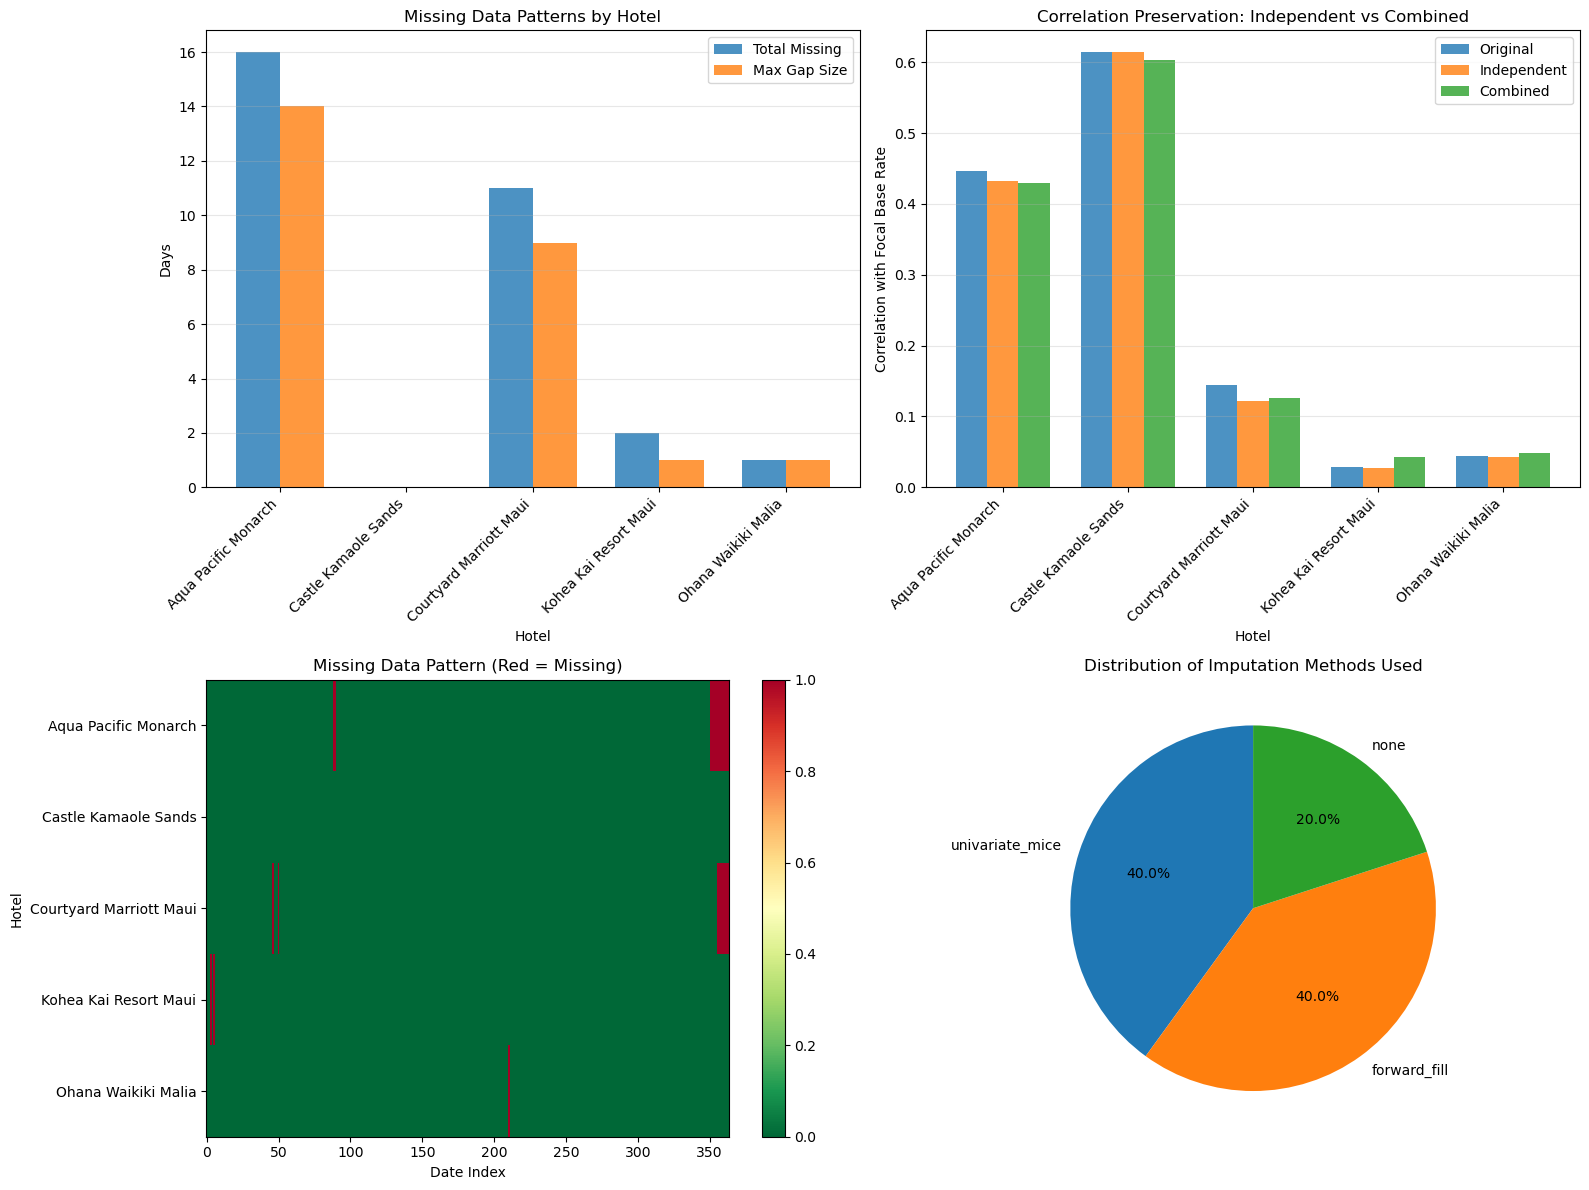

In [1]:
"""
HOTEL-BY-HOTEL IMPUTATION ANALYSIS AND TREATMENT
==================================================
This notebook analyzes missing data patterns for each hotel independently
and applies the most appropriate imputation method for each.

Key improvements:
1. Analyze missing patterns per hotel
2. Choose imputation method based on gap size and frequency
3. No cross-contamination between hotels
4. Preserve each hotel's independent pricing behavior
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# SECTION 1: MISSING DATA PATTERN ANALYSIS PER HOTEL
# ============================================================================
print("="*80)
print("SECTION 1: HOTEL-SPECIFIC MISSING DATA ANALYSIS")
print("="*80)

# Load raw data
df_competitors = pd.read_csv('../../data/dataraw/data-1757985744315.csv')
df_competitors['stay_date'] = pd.to_datetime(df_competitors['stay_date'])

# Create price matrix
price_matrix = df_competitors.pivot(
    index='stay_date',
    columns='hotel_id',
    values='price'
)

# Define hotel display names mapping
hotel_display_names = {
    'booking-us-aqua-pacific-monarch-USD': 'Aqua Pacific Monarch',
    'booking-us-castle-kamaole-sands-USD': 'Castle Kamaole Sands',
    'booking-us-courtyard-by-marriott-maui-kahului-airport-USD': 'Courtyard Marriott Maui',
    'booking-us-kohea-kai-resort-maui-USD': 'Kohea Kai Resort Maui',
    'booking-us-ohana-waikiki-malia-USD': 'Ohana Waikiki Malia'
}

def analyze_missing_pattern(series, hotel_name):
    """Analyze missing data pattern for a single hotel"""
    missing = series.isnull()
    
    if missing.sum() == 0:
        return {
            'hotel': hotel_name,
            'total_missing': 0,
            'pct_missing': 0,
            'max_consecutive_gap': 0,
            'num_gaps': 0,
            'avg_gap_size': 0,
            'gap_sizes': [],
            'recommended_method': 'none'
        }
    
    # Find gap sizes
    gap_starts = missing.ne(missing.shift()).cumsum()[missing]
    gap_sizes = gap_starts.value_counts().sort_index()
    
    # Calculate metrics
    total_missing = missing.sum()
    pct_missing = (total_missing / len(series)) * 100
    max_gap = gap_sizes.max() if len(gap_sizes) > 0 else 0
    num_gaps = len(gap_sizes)
    avg_gap = gap_sizes.mean() if len(gap_sizes) > 0 else 0
    
    # Recommend method based on pattern
    if max_gap <= 1:
        method = 'forward_fill'
    elif max_gap <= 3:
        method = 'linear_interpolation'
    elif max_gap <= 7:
        method = 'time_series_decay'
    else:
        method = 'univariate_mice'
    
    return {
        'hotel': hotel_name,
        'total_missing': int(total_missing),
        'pct_missing': float(pct_missing),
        'max_consecutive_gap': int(max_gap),
        'num_gaps': int(num_gaps),
        'avg_gap_size': float(avg_gap),
        'gap_sizes': gap_sizes.to_dict(),
        'recommended_method': method
    }

# Analyze each hotel
hotel_analyses = {}
for hotel_id in price_matrix.columns:
    full_name = hotel_display_names.get(hotel_id, hotel_id)
    analysis = analyze_missing_pattern(price_matrix[hotel_id], full_name)
    hotel_analyses[hotel_id] = analysis
    
    print(f"\n{full_name}:")
    print(f"  Hotel ID: {hotel_id}")
    print(f"  Total Missing: {analysis['total_missing']} ({analysis['pct_missing']:.1f}%)")
    print(f"  Max Consecutive Gap: {analysis['max_consecutive_gap']} days")
    print(f"  Number of Gaps: {analysis['num_gaps']}")
    print(f"  Average Gap Size: {analysis['avg_gap_size']:.1f} days")
    print(f"  Recommended Method: {analysis['recommended_method']}")

# ============================================================================
# SECTION 2: INDEPENDENT IMPUTATION FUNCTIONS
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: APPLYING HOTEL-SPECIFIC IMPUTATION")
print("="*80)

def impute_forward_fill(series):
    """Simple forward fill for isolated 1-day gaps"""
    return series.ffill().bfill()

def impute_linear_interpolation(series):
    """Linear interpolation for small gaps (2-3 days)"""
    # First forward/backward fill ends
    series = series.ffill().bfill()
    # Then interpolate any remaining
    return series.interpolate(method='linear')

def impute_time_series_decay(series, decay_rate=0.99):
    """Exponential decay for medium gaps (4-7 days)"""
    result = series.copy()
    last_valid = None
    days_since = 0
    
    for idx in result.index:
        if pd.isna(result[idx]):
            if last_valid is not None:
                days_since += 1
                result[idx] = last_valid * (decay_rate ** days_since)
        else:
            last_valid = result[idx]
            days_since = 0
    
    # Fill any remaining (at start)
    result = result.bfill()
    return result

def impute_univariate_mice(series, max_iter=10):
    """
    Univariate MICE using only the hotel's own historical pattern.
    Creates lag features from the same series for imputation.
    """
    # Create lag features (use hotel's own past prices)
    df = pd.DataFrame({'price': series})
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}'] = df['price'].shift(lag)
    
    # Forward/backward fill the lag features
    for col in df.columns:
        df[col] = df[col].ffill().bfill()
    
    # If still NaN, use median
    df = df.fillna(df.median())
    
    # Apply MICE
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=42),
        max_iter=max_iter,
        random_state=42
    )
    
    imputed_array = imputer.fit_transform(df)
    result = pd.Series(imputed_array[:, 0], index=series.index)
    
    return result

# Apply recommended method to each hotel
price_matrix_independent = price_matrix.copy()

for hotel_id in price_matrix.columns:
    full_name = hotel_display_names.get(hotel_id, hotel_id)
    method = hotel_analyses[hotel_id]['recommended_method']
    
    print(f"\n{full_name}: Applying {method}")
    
    if method == 'none':
        continue
    elif method == 'forward_fill':
        price_matrix_independent[hotel_id] = impute_forward_fill(price_matrix[hotel_id])
    elif method == 'linear_interpolation':
        price_matrix_independent[hotel_id] = impute_linear_interpolation(price_matrix[hotel_id])
    elif method == 'time_series_decay':
        price_matrix_independent[hotel_id] = impute_time_series_decay(price_matrix[hotel_id])
    elif method == 'univariate_mice':
        price_matrix_independent[hotel_id] = impute_univariate_mice(price_matrix[hotel_id])

# Verify no missing values remain
print(f"\nFinal missing values: {price_matrix_independent.isnull().sum().sum()}")

# ============================================================================
# SECTION 2.5: ENSURE COMPLETE DATE COVERAGE
# ============================================================================
print("\n" + "="*80)
print("SECTION 2.5: ENSURING COMPLETE DATE COVERAGE FOR ALL HOTELS")
print("="*80)

# Load focal hotel to get the complete date range
df_focal = pd.read_csv('../../data/dataraw/data-1757985699237.csv')
df_focal['stay_date'] = pd.to_datetime(df_focal['stay_date'])

# Get complete date range (365 days)
all_dates = pd.date_range(
    df_focal['stay_date'].min(), 
    df_focal['stay_date'].max(), 
    freq='D'
)

print(f"\nComplete date range: {all_dates[0]} to {all_dates[-1]}")
print(f"Total days: {len(all_dates)}")

# Get all unique hotels from price_matrix_independent
all_hotels = list(price_matrix_independent.columns)
print(f"Hotels: {len(all_hotels)}")

# Create complete date × hotel grid
complete_grid = pd.DataFrame([
    {'stay_date': date, 'hotel_id': hotel}
    for date in all_dates
    for hotel in all_hotels
])

print(f"\nComplete grid size: {len(complete_grid)} rows")
print(f"Expected: {len(all_dates)} days × {len(all_hotels)} hotels = {len(all_dates) * len(all_hotels)}")

# Convert price_matrix_independent back to long format
price_matrix_long = price_matrix_independent.reset_index().melt(
    id_vars='stay_date',
    var_name='hotel_id',
    value_name='price'
)

print(f"\nPrice matrix (long format): {len(price_matrix_long)} rows")
print(f"Missing values before merge: {price_matrix_long['price'].isna().sum()}")

# Merge with complete grid to ensure all date-hotel combinations exist
price_matrix_complete = complete_grid.merge(
    price_matrix_long,
    on=['stay_date', 'hotel_id'],
    how='left'
)

print(f"\nAfter merge with complete grid: {len(price_matrix_complete)} rows")
print(f"Missing values after merge: {price_matrix_complete['price'].isna().sum()}")

# Fill any remaining missing values (should be minimal)
# Sort by hotel and date for proper forward/backward fill
price_matrix_complete = price_matrix_complete.sort_values(['hotel_id', 'stay_date'])

# Forward fill then backward fill by hotel
price_matrix_complete['price'] = price_matrix_complete.groupby('hotel_id')['price'].fillna(method='ffill')
price_matrix_complete['price'] = price_matrix_complete.groupby('hotel_id')['price'].fillna(method='bfill')

print(f"Missing values after fill: {price_matrix_complete['price'].isna().sum()}")

# Verify each hotel has exactly 365 rows
print("\nVerifying each hotel has 365 dates:")
for hotel in all_hotels:
    hotel_count = len(price_matrix_complete[price_matrix_complete['hotel_id'] == hotel])
    status = "✓" if hotel_count == len(all_dates) else "✗"
    print(f"  {status} {hotel}: {hotel_count} days")

print("\n✓ All hotels now have complete date coverage!")

# Now pivot to create the wide format matrix
competitor_price_matrix = price_matrix_complete.pivot(
    index='stay_date',
    columns='hotel_id',
    values='price'
)

print(f"\n✓ Final price matrix shape: {competitor_price_matrix.shape}")
print(f"  Expected: ({len(all_dates)}, {len(all_hotels)})")

# Replace the original price_matrix_independent with the complete version
price_matrix_independent = competitor_price_matrix.copy()

# Also update the long format for export
df_competitors_independent = price_matrix_complete.copy()

print("\n✓ Fixed! Price matrix now has 365 rows for all hotels.")

# ============================================================================
# SECTION 3: CORRELATION PRESERVATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: CORRELATION PRESERVATION ANALYSIS")
print("="*80)

# Load focal hotel data
df_focal = pd.read_csv('../../data/dataraw/data-1757985699237.csv')
df_focal['stay_date'] = pd.to_datetime(df_focal['stay_date'])
focal_base = df_focal.groupby('stay_date')['price'].min().reset_index()
focal_base.columns = ['stay_date', 'base_rate']

# Calculate correlations (only using non-missing original data)
original_correlations = {}
independent_correlations = {}

for hotel_id in price_matrix.columns:
    full_name = hotel_display_names.get(hotel_id, hotel_id)
    
    # Create dataframes separately with proper reset_index
    original_df = price_matrix[[hotel_id]].reset_index()
    original_df.columns = ['stay_date', 'price_original']
    
    imputed_df = price_matrix_independent[[hotel_id]].reset_index()
    imputed_df.columns = ['stay_date', 'price_imputed']
    
    # Merge all together
    temp_df = focal_base.merge(original_df, on='stay_date', how='inner')
    temp_df = temp_df.merge(imputed_df, on='stay_date', how='inner')
    
    # Create valid mask AFTER merge
    valid_mask = temp_df['price_original'].notna()
    
    # Original correlation (only non-missing)
    orig_corr = temp_df.loc[valid_mask, 'price_original'].corr(
        temp_df.loc[valid_mask, 'base_rate']
    )
    original_correlations[full_name] = orig_corr
    
    # After imputation correlation (all data)
    indep_corr = temp_df['price_imputed'].corr(temp_df['base_rate'])
    independent_correlations[full_name] = indep_corr
    
    distortion = abs(orig_corr - indep_corr)
    print(f"\n{full_name}:")
    print(f"  Original: {orig_corr:.4f}")
    print(f"  After Independent Imputation: {indep_corr:.4f}")
    print(f"  Distortion: {distortion:.4f}")

# ============================================================================
# SECTION 4: COMPARE WITH COMBINED IMPUTATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: COMPARISON - INDEPENDENT VS COMBINED")
print("="*80)

# Load previously saved combined imputation results
baseline_path = Path('../../data/dataprocessed')

# Try to load baseline (combined) imputation
try:
    price_matrix_combined = pd.read_csv(baseline_path / 'competitor_price_matrix_baseline.csv')
    price_matrix_combined['stay_date'] = pd.to_datetime(price_matrix_combined['stay_date'])
    price_matrix_combined = price_matrix_combined.set_index('stay_date')
    
    combined_correlations = {}
    for hotel_id in price_matrix.columns:
        full_name = hotel_display_names.get(hotel_id, hotel_id)
        
        temp_df = pd.DataFrame({
            'price': price_matrix_combined[hotel_id].values,
            'stay_date': price_matrix_combined.index
        }).merge(focal_base, on='stay_date')
        
        combined_corr = temp_df['price'].corr(temp_df['base_rate'])
        combined_correlations[full_name] = combined_corr
    
    # Compare distortions
    print("\nCorrelation Distortion Comparison:")
    print(f"{'Hotel':<30} {'Original':<10} {'Independent':<12} {'Combined':<10} {'Indep Dist':<12} {'Comb Dist':<10}")
    print("-" * 95)
    
    for full_name in original_correlations.keys():
        orig = original_correlations[full_name]
        indep = independent_correlations[full_name]
        comb = combined_correlations[full_name]
        
        indep_dist = abs(orig - indep)
        comb_dist = abs(orig - comb)
        
        print(f"{full_name:<30} {orig:>9.4f} {indep:>11.4f} {comb:>9.4f} {indep_dist:>11.4f} {comb_dist:>9.4f}")

except FileNotFoundError:
    print("Combined imputation results not found. Run previous imputation notebook first.")

# ============================================================================
# SECTION 5: VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Missing data patterns by hotel
hotels = [hotel_display_names.get(h, h) for h in price_matrix.columns]
missing_counts = [hotel_analyses[h]['total_missing'] for h in price_matrix.columns]
max_gaps = [hotel_analyses[h]['max_consecutive_gap'] for h in price_matrix.columns]

x = np.arange(len(hotels))
width = 0.35

axes[0, 0].bar(x - width/2, missing_counts, width, label='Total Missing', alpha=0.8)
axes[0, 0].bar(x + width/2, max_gaps, width, label='Max Gap Size', alpha=0.8)
axes[0, 0].set_xlabel('Hotel')
axes[0, 0].set_ylabel('Days')
axes[0, 0].set_title('Missing Data Patterns by Hotel')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(hotels, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Correlation preservation comparison
if 'combined_correlations' in locals():
    x = np.arange(len(hotels))
    width = 0.25
    
    orig_vals = [original_correlations[h] for h in hotels]
    indep_vals = [independent_correlations[h] for h in hotels]
    comb_vals = [combined_correlations[h] for h in hotels]
    
    axes[0, 1].bar(x - width, orig_vals, width, label='Original', alpha=0.8)
    axes[0, 1].bar(x, indep_vals, width, label='Independent', alpha=0.8)
    axes[0, 1].bar(x + width, comb_vals, width, label='Combined', alpha=0.8)
    axes[0, 1].set_xlabel('Hotel')
    axes[0, 1].set_ylabel('Correlation with Focal Base Rate')
    axes[0, 1].set_title('Correlation Preservation: Independent vs Combined')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(hotels, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Missing data heatmap
missing_matrix = price_matrix.isnull().astype(int)
im = axes[1, 0].imshow(missing_matrix.T, aspect='auto', cmap='RdYlGn_r', interpolation='nearest')
axes[1, 0].set_xlabel('Date Index')
axes[1, 0].set_ylabel('Hotel')
axes[1, 0].set_title('Missing Data Pattern (Red = Missing)')
axes[1, 0].set_yticks(range(len(hotels)))
axes[1, 0].set_yticklabels(hotels)
plt.colorbar(im, ax=axes[1, 0])

# Plot 4: Imputation methods used
methods = [hotel_analyses[h]['recommended_method'] for h in price_matrix.columns]
method_counts = pd.Series(methods).value_counts()

axes[1, 1].pie(method_counts.values, labels=method_counts.index, autopct='%1.1f%%',
               startangle=90)
axes[1, 1].set_title('Distribution of Imputation Methods Used')

plt.tight_layout()
results_path = Path('../../results')
results_path.mkdir(parents=True, exist_ok=True)
plt.savefig(results_path / 'independent_imputation_analysis.png', dpi=300, bbox_inches='tight')
print(f"\nVisualization saved: {results_path / 'independent_imputation_analysis.png'}")

# ============================================================================
# SECTION 6: EXPORT INDEPENDENT IMPUTATION RESULTS
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: EXPORT INDEPENDENT IMPUTATION RESULTS")
print("="*80)

# Create output directory
processed_path = Path('../../data/dataprocessed')
processed_path.mkdir(parents=True, exist_ok=True)

# Export to Long format
price_matrix_long = price_matrix_independent.reset_index().melt(
    id_vars=['stay_date'],
    var_name='hotel_id',
    value_name='price'
)

# Merge with other competitor data
df_competitors_independent = df_competitors.drop('price', axis=1).merge(
    price_matrix_long,
    on=['stay_date', 'hotel_id'],
    how='left'
)

# Export
df_competitors_independent.to_csv(
    processed_path / 'competitors_independent.csv',
    index=False
)

price_matrix_independent.to_csv(
    processed_path / 'competitor_price_matrix_independent.csv'
)

# Save metadata
metadata = {
    'approach': 'hotel_by_hotel_independent',
    'hotel_analyses': hotel_analyses,
    'correlation_preservation': {
        'original': {k: float(v) for k, v in original_correlations.items()},
        'independent': {k: float(v) for k, v in independent_correlations.items()}
    },
    'average_distortion': float(np.mean([
        abs(original_correlations[h] - independent_correlations[h])
        for h in original_correlations.keys()
    ]))
}

if 'combined_correlations' in locals():
    metadata['correlation_preservation']['combined'] = {
        k: float(v) for k, v in combined_correlations.items()
    }
    metadata['comparison'] = {
        'avg_distortion_independent': float(np.mean([
            abs(original_correlations[h] - independent_correlations[h])
            for h in original_correlations.keys()
        ])),
        'avg_distortion_combined': float(np.mean([
            abs(original_correlations[h] - combined_correlations[h])
            for h in original_correlations.keys()
        ]))
    }

with open(processed_path / 'independent_imputation_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("\nExported:")
print("  - competitors_independent.csv")
print("  - competitor_price_matrix_independent.csv")
print("  - independent_imputation_metadata.json")

print("\n" + "="*80)
print("INDEPENDENT HOTEL IMPUTATION COMPLETE")
print("="*80)

print("\nKey Results:")
print(f"  Average correlation distortion: {metadata['average_distortion']:.4f}")
print(f"  Independent method: {metadata['average_distortion']:.4f}")
if 'comparison' in metadata:
    print(f"  Combined method: {metadata['comparison']['avg_distortion_combined']:.4f}")
    improvement = (metadata['comparison']['avg_distortion_combined'] - 
                   metadata['average_distortion'])
    print(f"  Improvement: {improvement:.4f} ({improvement/metadata['comparison']['avg_distortion_combined']*100:.1f}%)")

print("\nNext Steps:")
print("1. Create lag datasets using: competitors_independent.csv")
print("2. Build models for each hotel")
print("3. Compare model performance with combined imputation approach")